In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)

In [2]:
file_paths = {'in':'../../data/cleaned/activities/4439566437.csv'
             }

df = pd.read_csv(file_paths['in'])

# guarantee the timestamps are datetime objects
df['time'] = pd.to_datetime(df['time'])

In [3]:
if 'index' in df.columns:
    df.drop(['index'], axis=1, inplace=True)

In [4]:
df.head()

,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time,delta_time,moving_time,delta_dist,heading,speed,is_cruising,grade,elapsed_ascent,elapsed_descent,elapsed_elevation,training_window_id,filt_speed,filt_grade,inst_power
0,2020-12-06 18:36:38+00:00,4.439566e+09,0.0,884.8857,40.067950,-83.127786,1.0,1.0,1.0,NaN,NaN,6.259034,False,0.0,0.0,0.0,0.0,6,3.172414,0.0,8.172834
1,2020-12-06 18:36:39+00:00,4.439566e+09,0.0,884.8857,40.067975,-83.127779,2.0,1.0,2.0,0.001739,72.979474,6.259034,False,0.0,0.0,0.0,0.0,6,4.504257,0.0,12.736414
2,2020-12-06 18:36:40+00:00,4.439566e+09,0.0,884.8857,40.067999,-83.127771,3.0,1.0,3.0,0.001739,72.979474,6.259034,False,0.0,0.0,0.0,0.0,6,5.225672,0.0,15.678322
3,2020-12-06 18:36:41+00:00,4.439566e+09,0.0,884.8857,40.068021,-83.127801,4.0,1.0,4.0,0.002197,143.746162,7.909226,False,0.0,0.0,0.0,0.0,6,5.034892,0.0,14.863570
4,2020-12-06 18:36:42+00:00,4.439566e+09,0.0,884.8857,40.068023,-83.127808,5.0,1.0,5.0,0.000395,164.054604,1.422308,False,0.0,0.0,0.0,0.0,6,4.021185,0.0,10.963215


### Aggregation Ideas:

- Start / End Times
- Number of Rows, Segments
- Final Elapsed Time (s)
- Final Moving Time (s)
- Final Elapsed Distance (mi)
- Average Speed (MPH)
- Cruising Speed (MPH)
- Max Filtered Speed (MPH)
- Total Elapsed Acscent, Descent, Elevation Changes
- Training Window ID
- Average Power
- Best Avg.Power over 20 minute span (FTP)


In [13]:
df_a = pd.DataFrame(data=[{'key':0, 'color':'k'},{'key':1, 'color':'b'},{'key':2, 'color':'y'}])
#df_a = df_a.set_index('key')

In [14]:
df_b = pd.DataFrame(data=[{'key':0, 'count':12},{'key':1, 'count':44},{'key':2, 'count':25}])
#df_b = df_b.set_index('key')

In [18]:
#df_a.merge(df_b, on='key')

# Ride Start/ End Times

In [16]:
def get_time_endpoints(df):
    start_time = df.loc[0, 'time']
    end_time = df.loc[df.shape[0]-1, 'time']
    agg_dict = {'start_time':start_time, 'end_time':end_time}
    return agg_dict

In [17]:
get_time_endpoints(df)

{'start_time': Timestamp('2020-12-06 18:36:38+0000', tz='UTC'),
 'end_time': Timestamp('2020-12-06 18:36:38+0000', tz='UTC')}

# Row/ Segment Counts

In [73]:
def get_row_segment_counts(df):
    row_count = df.shape[0]
    segment_count = len(df['segment_id'].unique())
    agg_dict = {'row_count':row_count, 'segment_count':segment_count}
    return agg_dict

In [74]:
get_row_segment_counts(df)

{'row_count': 7013, 'segment_count': 24}

# Elapsed Durations

In [34]:
def get_durations(df):
    last_row = df.shape[0]-1
    elapsed_time = df.loc[last_row, 'elapsed_time']
    moving_time = df.loc[last_row, 'moving_time'] 
    elapsed_distance = df['delta_dist'].cumsum().iloc[last_row]
    elapsed_ascent = df.loc[last_row, 'elapsed_ascent']
    elapsed_descent = df.loc[last_row, 'elapsed_descent']
    elapsed_elevation = df.loc[last_row, 'elapsed_elevation']
    
    agg_dict = {'ride_elapsed_time':elapsed_time, 'ride_moving_time':moving_time, 'elapsed_distance':elapsed_distance, 
                'elapsed_ascent':elapsed_ascent, 'elapsed_descent':elapsed_descent, 'elapsed_elevation':elapsed_elevation}
    return agg_dict

In [35]:
get_durations(df)

{'ride_elapsed_time': 8109.0,
 'ride_moving_time': 7013.0,
 'elapsed_distance': 23.87576344132953,
 'elapsed_ascent': 727.0695999999989,
 'elapsed_descent': 727.0695999999989,
 'elapsed_elevation': 1454.1391999999978}

# Speed Summary

In [36]:
def get_speed_summary(df):
    ride_avg_speed =  np.mean(df.loc[:, 'speed'])
    
    filt_cruising = df.loc[:,'is_cruising']==True
    ride_cruise_speed = np.mean(df.loc[filt_cruising, 'speed'])
    
    ride_max_speed = np.max(df.loc[:, 'filt_speed'])
    
    agg_dict = {'ride_avg_speed':ride_avg_speed, 'ride_cruise_speed':ride_cruise_speed, 'ride_max_speed':ride_max_speed}
    return agg_dict

In [37]:
get_speed_summary(df)

{'ride_avg_speed': 12.269407362765472,
 'ride_cruise_speed': 14.820174850339143,
 'ride_max_speed': 26.626494943666746}

# Training Window

In [40]:
def get_training_window_id(df):
    training_window_id =  df.loc[0, 'training_window_id']
    
    agg_dict = {'training_window_id':training_window_id}
    return agg_dict

In [41]:
get_training_window_id(df)

{'training_window_id': 6}

# Basic Power Summary

In [42]:
def get_basic_power_summary(df):
    ride_avg_power = np.mean(df.loc[:, 'inst_power'])    
    ride_max_power = np.max(df.loc[:, 'inst_power'])
    
    agg_dict = {'ride_avg_power':ride_avg_power, 'ride_max_power':ride_max_power}
    return agg_dict

In [43]:
get_basic_power_summary(df)

{'ride_avg_power': 106.50571309574859, 'ride_max_power': 1006.2450714830736}

# FTP Estimation
Since 1 row represents 1 second of data... Let's pretend that every row is contiguous in time. 

Then I want to find the index window 1200 rows wide (20 minutes * 60 sec/min) with the highest average power

In [70]:
def get_power_ftp(df):
    # 1200 corresponds to 1200 samples at 1 sec/sample for 20 minutes
    power_window = df['inst_power'].rolling(window=1200).mean()
    peak_20min_power = np.max(power_window)
    
    agg_dict = {'peak_20min_power':peak_20min_power}
    return agg_dict

In [71]:
get_power_ftp(df)

{'peak_20min_power': 137.13728844679656}

### Prototyping below

In [61]:
power_window = df['inst_power'].rolling(window=1200).mean()
max_ftp = np.max(power_window)
k_max = np.argmax(power_window)
print(f'k_max={k_max} for {max_ftp} Watts')

k_max=6611 for 137.13728844679656 Watts


In [66]:
np.mean(df.loc[k_max-1200+1:k_max, 'inst_power'])

137.13728844679653

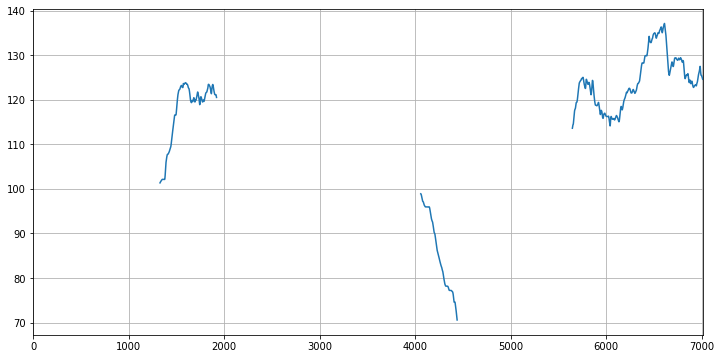

In [58]:
fig = plt.figure(figsize=(12,6))

_ = plt.plot(power_window)
_ = plt.grid()
_ = plt.xlim([0, df.shape[0]])

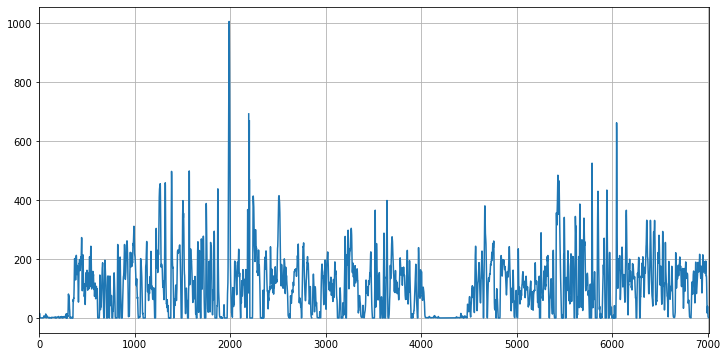

In [59]:
fig = plt.figure(figsize=(12,6))

_ = plt.plot(df['inst_power'])
_ = plt.grid()
_ = plt.xlim([0, df.shape[0]])